In [41]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.3'
spark_version = 'spark-3.5.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [42]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [43]:

# 1. Read the home_sales_revised.csv from the provided AWS S3 bucket location into a PySpark DataFrame.
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/hillz246/digital_market_csv/refs/heads/main/cleaned_data.csv"


In [44]:
spark.sparkContext.addFile(url)
digital_market_df = spark.read.csv(SparkFiles.get("cleaned_data.csv"), sep=",", header=True)
digital_market_df.show()


+----------+---+------+------+---------------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+
|CustomerID|Age|Gender|Income|CampaignChannel| CampaignType|AdSpend|ClickThroughRate|ConversionRate|WebsiteVisits|PagesPerVisit|TimeOnSite|SocialShares|EmailOpens|EmailClicks|PreviousPurchases|LoyaltyPoints|Conversion|
+----------+---+------+------+---------------+-------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+----------+
|      8000| 56|Female|136912|   Social Media|    Awareness|6497.87|          0.0439|         0.088|            0|        2.399|    7.3968|          19|         6|          9|                4|          688|         1|
|      8001| 69|  Male| 41760|          Email|    Retention|3898.67|          0.1557|        0.1827|           42|       2.9

In [45]:
# Get the data types of the columns
digital_market_df.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- CampaignChannel: string (nullable = true)
 |-- CampaignType: string (nullable = true)
 |-- AdSpend: string (nullable = true)
 |-- ClickThroughRate: string (nullable = true)
 |-- ConversionRate: string (nullable = true)
 |-- WebsiteVisits: string (nullable = true)
 |-- PagesPerVisit: string (nullable = true)
 |-- TimeOnSite: string (nullable = true)
 |-- SocialShares: string (nullable = true)
 |-- EmailOpens: string (nullable = true)
 |-- EmailClicks: string (nullable = true)
 |-- PreviousPurchases: string (nullable = true)
 |-- LoyaltyPoints: string (nullable = true)
 |-- Conversion: string (nullable = true)



In [46]:
from pyspark.sql.functions import col
# List of columns that should be converted to Integer or Float
int_columns = ["CustomerID", "Age", "LoyaltyPoints", "PreviousPurchases", "SocialShares", "EmailOpens", "EmailClicks", "WebsiteVisits", "Income", "Conversion"]
float_columns = ["AdSpend", "ClickThroughRate", "ConversionRate", "PagesPerVisit", "TimeOnSite"]
# Convert integer columns
for col_name in int_columns:
    digital_market_df = digital_market_df.withColumn(col_name, col(col_name).cast("int"))
# Convert float columns
for col_name in float_columns:
    digital_market_df = digital_market_df.withColumn(col_name, col(col_name).cast("float"))
# Verify the changes
digital_market_df.printSchema()
digital_market_df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- CampaignChannel: string (nullable = true)
 |-- CampaignType: string (nullable = true)
 |-- AdSpend: float (nullable = true)
 |-- ClickThroughRate: float (nullable = true)
 |-- ConversionRate: float (nullable = true)
 |-- WebsiteVisits: integer (nullable = true)
 |-- PagesPerVisit: float (nullable = true)
 |-- TimeOnSite: float (nullable = true)
 |-- SocialShares: integer (nullable = true)
 |-- EmailOpens: integer (nullable = true)
 |-- EmailClicks: integer (nullable = true)
 |-- PreviousPurchases: integer (nullable = true)
 |-- LoyaltyPoints: integer (nullable = true)
 |-- Conversion: integer (nullable = true)

+----------+---+------+------+---------------+------------+-------+----------------+--------------+-------------+-------------+----------+------------+----------+-----------+-----------------+-------------+---------

In [47]:
# 2. Create a temporary view of the DataFrame.
digital_market_df.createOrReplaceTempView('CampaignMarket')

Campaign Success Metrics

1. **conversion Rate**:  Calculate the conversion rate as the percentage of users who converted (e.g., made a purchase) divided by the total number of users

In [48]:
# Run SQL query to calculate Conversion Rate
conversion_rate_sql = spark.sql("""
    SELECT
        (SUM(Conversion) / COUNT(*)) * 100 AS ConversionRate
    FROM CampaignMarket
""")

# Show the result
conversion_rate_sql.show(truncate=False)

+-----------------+
|ConversionRate   |
+-----------------+
|87.64999999999999|
+-----------------+



In [49]:
# Run SQL query to calculate Conversion Rate (extra - question: which one to keep)
conversion_rate_sql = spark.sql("""
    SELECT
        CampaignType,
        SUM(Conversion) / SUM(WebsiteVisits) AS ConversionRate
    FROM CampaignMarket
    GROUP BY CampaignType
""")

# Show the result
conversion_rate_sql.show(truncate=False)





+-------------+--------------------+
|CampaignType |ConversionRate      |
+-------------+--------------------+
|Consideration|0.033816425120772944|
|Retention    |0.03491360397818683 |
|Awareness    |0.03455771809353541 |
|Conversion   |0.03829820853660945 |
+-------------+--------------------+



2. Cost per Acquisition (CPA): Calculate the CPA by dividing the total campaign cost by the number of acquired customers.

In [50]:
# Run SQL query to calculate Cost per Acquisition (CPA)
cpa_sql = spark.sql("""
    SELECT
        (SUM(AdSpend) / SUM(CASE WHEN Conversion = 1 THEN 1 ELSE 0 END)) AS CPA
    FROM CampaignMarket
""")

# Show the result
cpa_sql.show(truncate=False)

+-----------------+
|CPA              |
+-----------------+
|5705.584547592311|
+-----------------+



3. Click-Through Rate (CTR): Calculate the CTR as the percentage of clicks relative to impressions (views).

In [51]:
# Run SQL query to calculate Click-Through Rate (CTR)
ctr_sql = spark.sql("""
    SELECT
        (SUM(ClickThroughRate) / COUNT(*)) * 100 AS CTR
    FROM CampaignMarket
""")

# Show the result
ctr_sql.show(truncate=False)

+------------------+
|CTR               |
+------------------+
|15.482914998359046|
+------------------+



4. Average Transaction Value: Calculate the average transaction value (e.g., average purchase amount) based on available data.

In [52]:
# Run SQL query to calculate Average Transaction Value (Alternative CLV estimate)
clv_sql = spark.sql("""
    SELECT
        AVG(total_ad_spend) AS AvgTransactionValue
    FROM (
        SELECT
            CustomerID,
            SUM(AdSpend) AS total_ad_spend
        FROM CampaignMarket
        GROUP BY CustomerID
    ) AS customer_ad_spend
""")

# Show the result
clv_sql.show(truncate=False)

+-------------------+
|AvgTransactionValue|
+-------------------+
|5000.944855964661  |
+-------------------+



5.  Conversion Rate by Campaign Channel: Visualize how conversion rates vary across different campaign channels.

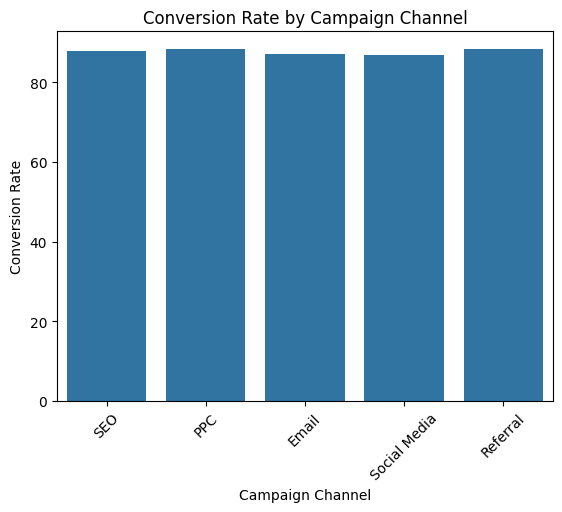

In [53]:
# Run SQL query to calculate Conversion Rate by CampaignChannel (extra)
conversion_rate_sql = spark.sql("""
    SELECT
        CampaignChannel,
        (SUM(Conversion) / COUNT(*)) * 100 AS ConversionRate
    FROM CampaignMarket
    GROUP BY CampaignChannel
""")

# Convert the result to a Pandas DataFrame for plotting
conversion_rate_pd = conversion_rate_sql.toPandas()

# Now, use seaborn and matplotlib to plot the barplot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar plot
sns.barplot(x='CampaignChannel', y='ConversionRate', data=conversion_rate_pd)

# Customize the plot
plt.xlabel("Campaign Channel")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Campaign Channel")
plt.xticks(rotation=45)

# Show the plot
plt.show()

5.  Income Segmentation: To explore how income levels impact customer behavior, you can create a box plot

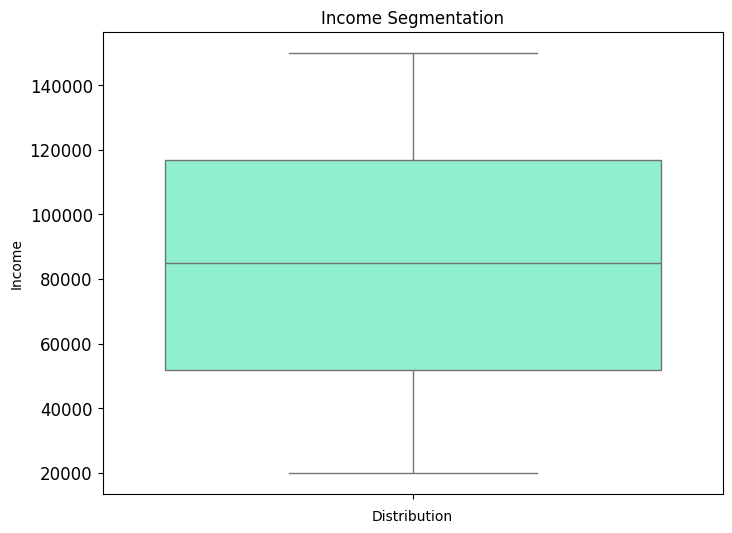

In [54]:
# Run SQL query to select the 'Income' data (question: how to display values of income in plot)
income_sql = spark.sql("""
    SELECT Income
    FROM CampaignMarket
""")

# Convert the result to a Pandas DataFrame for plotting
income_pd = income_sql.toPandas()

# Now, use seaborn and matplotlib to create the box plot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the figure with a custom size
plt.figure(figsize=(8, 6))

# Create the box plot for 'Income' distribution
sns.boxplot(y=income_pd['Income'].values, color='aquamarine')

# Customize the plot
plt.xlabel("Distribution")
plt.ylabel("Income")
plt.title("Income Segmentation")


# Display numbers (tick marks) on both axes

plt.xticks(rotation=90)  # Rotate x-axis labels if needed (to avoid overlap)
plt.yticks(fontsize=12)  # Adjust fontsize for y-axis ticks if desired

# Show the plot
plt.show()

Customer Retention Metrics:
1. Returning Visitors: To monitor returning visitors, you can track the number of unique users who visit your website more than once

In [55]:
# Run a Spark SQL query to count the number of returning visitors (WebsiteVisits > 1)
returning_visitors_sql = spark.sql("""
    SELECT COUNT(*) AS returning_visitors
    FROM CampaignMarket
    WHERE WebsiteVisits > 1
""")

# Show the result
returning_visitors_sql.show()

+------------------+
|returning_visitors|
+------------------+
|              7700|
+------------------+



2. Email Engagement: Measure email opens, clicks, and conversions based on available data (e.g., ‘EmailOpens’, ‘EmailClicks’, ‘Conversion’).

In [56]:
# Run a Spark SQL query to calculate average of 'EmailOpens' and 'EmailClicks'
avg_email_sql = spark.sql("""
    SELECT
        AVG(EmailOpens) AS avg_email_opens,
        AVG(EmailClicks) AS avg_email_clicks
    FROM CampaignMarket
""")

# Show the result
avg_email_sql.show()

+---------------+----------------+
|avg_email_opens|avg_email_clicks|
+---------------+----------------+
|       9.476875|        4.467375|
+---------------+----------------+



3. Previous Purchases: Understand repeat purchase behavior by analyzing how many times customers made purchases.

In [57]:
# Run a Spark SQL query to count the number of repeat purchases (PreviousPurchases > 1)
repeat_purchase_sql = spark.sql("""
    SELECT COUNT(*) AS repeat_purchase_count
    FROM CampaignMarket
    WHERE PreviousPurchases > 1
""")

# Show the result
repeat_purchase_sql.show()

+---------------------+
|repeat_purchase_count|
+---------------------+
|                 6368|
+---------------------+



In [58]:
# Uncache the home_sales temporary table.
spark.sql('uncache table CampaignMarket')

DataFrame[]

In [59]:
# Check if the home_sales is no longer cached
spark.catalog.isCached('CampaignMarket')

False

Machine learning

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from google.colab import drive
from pathlib import Path

In [61]:
digital_market_df.head()

Row(CustomerID=8000, Age=56, Gender='Female', Income=136912, CampaignChannel='Social Media', CampaignType='Awareness', AdSpend=6497.8701171875, ClickThroughRate=0.04390000179409981, ConversionRate=0.08799999952316284, WebsiteVisits=0, PagesPerVisit=2.3989999294281006, TimeOnSite=7.3968000411987305, SocialShares=19, EmailOpens=6, EmailClicks=9, PreviousPurchases=4, LoyaltyPoints=688, Conversion=1)

In [62]:
digital_market_df.dtypes

[('CustomerID', 'int'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('Income', 'int'),
 ('CampaignChannel', 'string'),
 ('CampaignType', 'string'),
 ('AdSpend', 'float'),
 ('ClickThroughRate', 'float'),
 ('ConversionRate', 'float'),
 ('WebsiteVisits', 'int'),
 ('PagesPerVisit', 'float'),
 ('TimeOnSite', 'float'),
 ('SocialShares', 'int'),
 ('EmailOpens', 'int'),
 ('EmailClicks', 'int'),
 ('PreviousPurchases', 'int'),
 ('LoyaltyPoints', 'int'),
 ('Conversion', 'int')]

In [63]:
# Convert PySpark DataFrame to Pandas DataFrame
digital_market_pd = digital_market_df.toPandas() # Display the first few rows digital_market_pd.head()
digital_market_pd

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870117,0.0439,0.0880,0,2.3990,7.3968,19,6,9,4,688,1
1,8001,69,Male,41760,Email,Retention,3898.669922,0.1557,0.1827,42,2.9171,5.3525,5,2,7,2,3459,1
2,8002,46,Female,88456,PPC,Awareness,1546.430054,0.2775,0.0764,2,8.2236,13.7949,0,11,2,8,2337,1
3,8003,32,Female,44085,PPC,Conversion,539.530029,0.1376,0.0880,47,4.5409,14.6884,89,2,2,0,2463,1
4,8004,60,Female,83964,PPC,Conversion,1678.040039,0.2529,0.1099,0,2.0468,13.9934,6,6,6,8,4345,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,15995,21,Male,24849,Email,Awareness,8518.309570,0.2438,0.1168,23,9.6936,14.2278,70,13,6,7,286,0
7996,15996,43,Female,44718,SEO,Retention,1424.609985,0.2367,0.1901,49,9.4990,3.5011,52,13,1,5,1502,0
7997,15997,28,Female,125471,Referral,Consideration,4609.529785,0.0565,0.1338,35,2.8532,14.6183,38,16,0,3,738,1
7998,15998,19,Female,107862,PPC,Consideration,9476.110352,0.0240,0.1384,49,1.0030,3.8766,86,1,5,7,2709,1


In [64]:
digital_market_pd.shape

(8000, 18)

In [65]:
# Set CustomerID as the index
digital_market_pd.set_index("CustomerID", inplace=True)
# Display the first few rows
digital_market_pd.head()

,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
CustomerID,,,,,,,,,,,,,,,,,
8000,56,Female,136912,Social Media,Awareness,6497.870117,0.0439,0.0880,0,2.3990,7.3968,19,6,9,4,688,1
8001,69,Male,41760,Email,Retention,3898.669922,0.1557,0.1827,42,2.9171,5.3525,5,2,7,2,3459,1
8002,46,Female,88456,PPC,Awareness,1546.430054,0.2775,0.0764,2,8.2236,13.7949,0,11,2,8,2337,1
8003,32,Female,44085,PPC,Conversion,539.530029,0.1376,0.0880,47,4.5409,14.6884,89,2,2,0,2463,1
8004,60,Female,83964,PPC,Conversion,1678.040039,0.2529,0.1099,0,2.0468,13.9934,6,6,6,8,4345,1


In [66]:
digital_market_pd.dtypes

,0
Age,int32
Gender,object
Income,int32
CampaignChannel,object
CampaignType,object
AdSpend,float32
ClickThroughRate,float32
ConversionRate,float32
WebsiteVisits,int32
PagesPerVisit,float32


In [67]:
digital_market_pd.columns

Index(['Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend',
       'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit',
       'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks',
       'PreviousPurchases', 'LoyaltyPoints', 'Conversion'],
      dtype='object')

In [68]:
#import
import pandas as pd

#convert categorial data to numeric with 'pd.get_dummies')
numeric_market_df = pd.get_dummies(digital_market_pd, dtype="int64")
numeric_market_df

,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,...,Gender_Male,CampaignChannel_Email,CampaignChannel_PPC,CampaignChannel_Referral,CampaignChannel_SEO,CampaignChannel_Social Media,CampaignType_Awareness,CampaignType_Consideration,CampaignType_Conversion,CampaignType_Retention
CustomerID,,,,,,,,,,,,,,,,,,,,,
8000,56,136912,6497.870117,0.0439,0.0880,0,2.3990,7.3968,19,6,...,0,0,0,0,0,1,1,0,0,0
8001,69,41760,3898.669922,0.1557,0.1827,42,2.9171,5.3525,5,2,...,1,1,0,0,0,0,0,0,0,1
8002,46,88456,1546.430054,0.2775,0.0764,2,8.2236,13.7949,0,11,...,0,0,1,0,0,0,1,0,0,0
8003,32,44085,539.530029,0.1376,0.0880,47,4.5409,14.6884,89,2,...,0,0,1,0,0,0,0,0,1,0
8004,60,83964,1678.040039,0.2529,0.1099,0,2.0468,13.9934,6,6,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,21,24849,8518.309570,0.2438,0.1168,23,9.6936,14.2278,70,13,...,1,1,0,0,0,0,1,0,0,0
15996,43,44718,1424.609985,0.2367,0.1901,49,9.4990,3.5011,52,13,...,0,0,0,0,1,0,0,0,0,1
15997,28,125471,4609.529785,0.0565,0.1338,35,2.8532,14.6183,38,16,...,0,0,0,1,0,0,0,1,0,0


In [69]:
print(numeric_market_df["Conversion"].value_counts())
# Split our preprocessed data into our features and target arrays

y = numeric_market_df["Conversion"].values
X = numeric_market_df.drop(["Conversion"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

Conversion
1    7012
0     988
Name: count, dtype: int64


In [70]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [71]:
X

array([[5.60000000e+01, 1.36912000e+05, 6.49787012e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.90000000e+01, 4.17600000e+04, 3.89866992e+03, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.60000000e+01, 8.84560000e+04, 1.54643005e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.80000000e+01, 1.25471000e+05, 4.60952979e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.90000000e+01, 1.07862000e+05, 9.47611035e+03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.10000000e+01, 9.30020000e+04, 7.74362988e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [72]:
y

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

Neural Network

In [73]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [75]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [76]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8008 - loss: 0.5518
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8792 - loss: 0.4038
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8758 - loss: 0.3674
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8703 - loss: 0.3594
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8727 - loss: 0.3380
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8753 - loss: 0.3230
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8757 - loss: 0.3172
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8702 - loss: 0.3179
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8688 - loss: 0.3175
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8678 - loss: 0.3252
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8772 - loss: 0.3004
Epoch 12/100
188/188 ━━━━━━━━━━━━━━━━━━━━

In [78]:
# Evaluate the model using the test data - FIRST ATTEMPT
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

63/63 - 0s - 4ms/step - accuracy: 0.8885 - loss: 0.3083
Loss: 0.30827832221984863, Accuracy: 0.8884999752044678


In [82]:
# Export our model to HDF5 file
#  To Save a Tensorflow Model-- this is the code to do it:
# Export our model to HDF5 file
nn.save("digital_marketing_model.h5")

<Axes: >

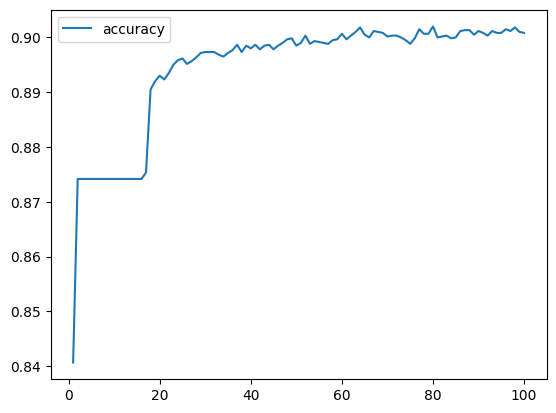

In [79]:
# plotting the accuracy
history_df = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
history_df.plot(y = 'accuracy')

# Random Forest

Fitting the Random Forest Model

Once the data is scaled, create a random forest instance and train it with the training data (X_train_scaled and y_train), define n_estimators=500 and random_state=78.

In [84]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report



In [85]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [87]:
# Fit the model and use .ravel()on the "y_train" data.
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

Making Predictions Using the Random Forest Model

Validate the trained model by predicting loan defaults using the testing data (X_test_scaled).

In [88]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

Model Evaluation

Evaluate model's results, by using sklearn to calculate the confusion matrix, the accuracy score and to generate the classification report.

In [89]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [90]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,31,202
Actual 1,3,1764


Accuracy Score : 0.8975
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.13      0.23       233
           1       0.90      1.00      0.95      1767

    accuracy                           0.90      2000
   macro avg       0.90      0.57      0.59      2000
weighted avg       0.90      0.90      0.86      2000



In [91]:
# Calculating the balance accuracy score
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
balanced_accuracy

0.5656747087155796

Feature Importance

In this section, you are asked to fetch the features' importance from the random forest model and display the top 10 most important features.

In [92]:
# Get the feature importance array
# List the top 10 most important features
importances = rf_model.feature_importances_
names = numeric_market_df.drop(["Conversion"], axis=1).columns

importance_df = pd.DataFrame({'importance': importances}, index=names).sort_values('importance', ascending=False)
display(importance_df.head(10))

,importance
PagesPerVisit,0.091300
TimeOnSite,0.088103
ConversionRate,0.083085
ClickThroughRate,0.080956
AdSpend,0.080528
LoyaltyPoints,0.079382
WebsiteVisits,0.068955
EmailOpens,0.063979
Income,0.058931
PreviousPurchases,0.055733


<ipython-input-93-5cc53d048b76>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df.head(10).importance, y=importance_df.head(10).index, palette="viridis")


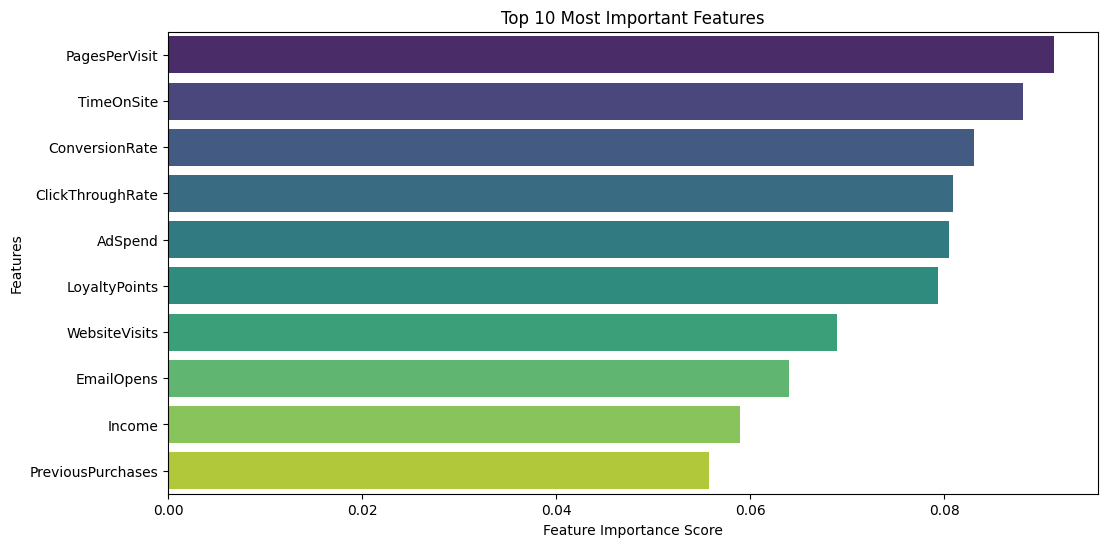

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df.head(10).importance, y=importance_df.head(10).index, palette="viridis")
# Add labels and title
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Most Important Features")
plt.show()